# Imports

In [13]:
import pandas as pd
import numpy as np 
import math
import os
import pickle
import gc 
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sys import getsizeof
from scipy import special
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import tensorflow as tf 

def q_func(x):
    q = 0.5 - 0.5*special.erf(x / np.sqrt(2))
    return q

def friis_calc(P,freq,dist,ple):
    '''
    Friis path loss equation
    P = Tx transmit power
    freq = Signal frequency
    dist = Transmission distance
    ple = Path loss exponent
    '''
    propagation_speed = 299792458
    l = propagation_speed / freq
    h_pl = P * l**2 / (16*math.pi**2)
    P_Rx = h_pl * dist**(-ple)
    return P_Rx

def plos_calc(h_dist, height_tx, height_rx, env='suburban'):
    '''
    % This function implements the LoS probability model from the paper
    % "Blockage Modeling for Inter-layer UAVs Communications in Urban
    % Environments" 
    % param h_dist    : horizontal distance between Tx and Rx (m)
    % param height_tx : height of Tx
    % param height_rx : height of Rx
    '''
    if env == 'suburban':
        a1 = 0.1
        a2 = 7.5e-4
        a3 = 8
    
    delta_h = height_tx - height_rx
    # pow_factor = 2 * h_dist * math.sqrt(a1*a2/math.pi) + a1 # NOTE: Use this pow_factor if assuming PPP building dist.
    pow_factor = h_dist * math.sqrt(a1*a2) # NOTE: Use this pow_factor if assuming ITU-R assumptions.
    if delta_h == 0:
        p = (1 - math.exp((-(height_tx)**2) / (2*a3**2))) ** pow_factor
    else:
        delta_h = abs(delta_h)
        p = (1 - (math.sqrt(2*math.pi)*a3 / delta_h) * abs(q_func(height_tx/a3) - q_func(height_rx/a3))) ** pow_factor
    return p

def sinr_lognormal_approx(h_dist, height, env='suburban'):
    '''
    To approximate the SNR from signal considering multipath fading and shadowing
    Assuming no interference due to CSMA, and fixed noise
    Inputs:
    h_dist = Horizontal Distance between Tx and Rx
    height = Height difference between Tx and Rx
    env = The operating environment (currently only suburban supported)
    '''
    # Signal properties
    P_Tx_dBm = 20 # Transmit power of 
    P_Tx = 10**(P_Tx_dBm/10) / 1000
    freq = 2.4e9 # Channel frequency (Hz)
    noise_dBm = -86
    noise = 10**(noise_dBm/10) / 1000
    if env == "suburban":
        # ENV Parameters Constants ----------------------------------
        # n_min = 2
        # n_max = 2.75
        # K_dB_min = 7.8
        # K_dB_max = 17.5
        # K_min = 10**(K_dB_min/10)
        # K_max = 10**(K_dB_max/10)
        # alpha = 11.25 # Env parameters for logarithm std dev of shadowing 
        # beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        n_min = 2
        n_max = 2.75
        K_dB_min = 1.4922
        K_dB_max = 12.2272
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 11.1852 # Env parameters for logarithm std dev of shadowing 
        beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        # -----------------------------------------------------------
    # Calculate fading parameters
    PLoS = plos_calc(h_dist, 0, height, env='suburban')
    theta_Rx = math.atan2(height, h_dist) * 180 / math.pi # Elevation angle in degrees
    ple = (n_min - n_max) * PLoS + n_max # Path loss exponent
    sigma_phi_dB = alpha*math.exp(-beta*theta_Rx)
    sigma_phi = 10**(sigma_phi_dB/10) # Logarithmic std dev of shadowing
    K = K_min * math.exp(math.log(K_max/K_min) * PLoS**2)
    omega = 1 # Omega of NCS (Rician)
    dist = math.sqrt(h_dist**2 + height**2)
    P_Rx = friis_calc(P_Tx, freq, dist, ple)
    # Approximate L-NCS RV (which is the SNR) as lognormal
    eta = math.log(10) / 10
    mu_phi = 10*math.log10(P_Rx)
    E_phi = math.exp(eta*mu_phi + eta**2*sigma_phi**2/2) # Mean of shadowing RV
    var_phi = math.exp(2*eta*mu_phi+eta**2*sigma_phi**2)*(math.exp(eta**2*sigma_phi**2)-1) # Variance of shadowing RV
    E_chi = (special.gamma(1+1)/(1+K))*special.hyp1f1(-1,1,-K)*omega
    var_chi = (special.gamma(1+2)/(1+K)**2)*special.hyp1f1(-2,1,-K)*omega**2 - E_chi**2
    E_SNR = E_phi * E_chi / noise # Theoretical mean of SINR
    var_SNR = ((var_phi+E_phi**2)*(var_chi+E_chi**2) - E_phi**2 * E_chi**2) / noise**2
    std_dev_SNR = math.sqrt(var_SNR)
    # sigma_ln = math.sqrt(math.log(var_SNR/E_SNR**2 + 1))
    # mu_ln = math.log(E_SNR) - sigma_ln**2/2
    return E_SNR, std_dev_SNR

def get_measured_throughput(sim_root_path, link="Downlink", single_path = False):
    '''
    Function to load the processed measured throughput data from CSV files stored in different subdirs in sim_root_path
    '''
    assert link in ["Downlink", "Uplink", "Video"], 'link must be one of "Downlink", "Uplink", "Video"'
    df_list = []
    if single_path:
        scenario_list = [sim_root_path]
    else:
        scenario_list = [f.path for f in os.scandir(sim_root_path) if f.is_dir()] # Get list of "unique" scenarios
    for scenario in tqdm(scenario_list):
        # Get the measured throughput samples under this scenario
        measured_df = pd.read_csv(os.path.join(scenario, link + "_Throughput.csv"))
        df_list.append(measured_df)
    return pd.concat(df_list)

def normalize_data(df_in, columns, link, save_details_path=None):
    '''
    columns: The pandas data columns to normalize, given as a list of column names
    link is the link type, for choosing the range of measured throughput to scale the data
    '''
    assert link in ["Downlink", "Uplink", "Video"], 'link must be one of "Downlink", "Uplink", "Video"'
    df = df_in.copy()
    # Define the ranges of parametrers
    max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
    max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
    min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
    min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
    max_height = 300
    min_height = 60
    max_h_dist = 1200
    min_h_dist = 0
    max_mcs = 7
    min_mcs = 0
    max_uav_speed = 26
    min_uav_speed = 0
    if link == "Downlink":
        max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
    elif link == "Uplink":
        max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
    elif link == "Video":
        max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
    min_throughput = 0

    # Normalize data (Min Max Normalization between [-1,1])
    if "Height" in columns:
        df["Height"] = df["Height"].apply(lambda x: 2*(x-min_height)/(max_height-min_height) - 1)
    if "U2G_H_Dist" in columns:
        df["U2G_H_Dist"] = df["U2G_H_Dist"].apply(lambda x: 2*(x-min_h_dist)/(max_h_dist-min_h_dist) - 1)
    if "Horizontal_Distance" in columns:
        df["Horizontal_Distance"] = df["Horizontal_Distance"].apply(lambda x: 2*(x-min_h_dist)/(max_h_dist-min_h_dist) - 1)
    if "Mean_SINR" in columns:
        df["Mean_SINR"] = df["Mean_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1) # Convert to dB space
    if "Std_Dev_SINR" in columns:
        df["Std_Dev_SINR"] = df["Std_Dev_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1) # Convert to dB space
    if "UAV_Sending_Interval" in columns:
        df["UAV_Sending_Interval"] = df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2})
    if "Packet_State" in columns:
        df['Packet_State'] = df['Packet_State'].replace({"Reliable":0, "QUEUE_OVERFLOW":1, "RETRY_LIMIT_REACHED":2, "Delay_Exceeded":3})
    if "Modulation" in columns:
        df['Modulation'] = df['Modulation'].replace({"BPSK":1, "QPSK":0.3333, 16:-0.3333, "QAM-16":-0.3333, "QAM16":-0.3333, 64:-1, "QAM-64":-1, "QAM64":-1})
    if "MCS" in columns:
        df["MCS"] = df["MCS"].apply(lambda x: 2*(x-min_mcs)/(max_mcs-min_mcs) - 1)
    if "MCS_Index" in columns:
        df["MCS_Index"] = df["MCS_Index"].apply(lambda x: 2*(x-min_mcs)/(max_mcs-min_mcs) - 1)
    if "UAV_Speed" in columns:
        df["UAV_Speed"] = df["UAV_Speed"].apply(lambda x: 2*(x-min_uav_speed)/(max_uav_speed-min_uav_speed) - 1)
    if "Throughput" in columns:
        df["Throughput"] = df["Throughput"].apply(lambda x: 2*(x-min_throughput)/(max_throughput-min_throughput) - 1)


    # Record details of inputs and output for model
    if save_details_path is not None:
        f = open(os.path.join(save_details_path,"model_details.txt"), "w")
        f.write("Max Height (m): {}\n".format(max_height))
        f.write("Min Height (m): {}\n".format(min_height))
        f.write("Max H_Dist (m): {}\n".format(max_h_dist))
        f.write("Min H_Dist (m): {}\n".format(min_h_dist))
        f.write("Max Mean SINR (dB): {}\n".format(max_mean_sinr))
        f.write("Min Mean SINR (dB): {}\n".format(min_mean_sinr))
        f.write("Max Std Dev SINR (dB): {}\n".format(max_std_dev_sinr))
        f.write("Min Std Dev SINR (dB): {}\n".format(min_std_dev_sinr))
        f.write("Max UAV Speed (m/s): {}\n".format(max_uav_speed))
        f.write("Min UAV Speed (m/s): {}\n".format(min_uav_speed))
        f.write("Max Measured Throughput (bytes/sec): {}\n".format(max_throughput))
        f.write("Min Measured Throughput (bytes/sec): {}\n".format(min_throughput))
        f.write("[BPSK: 1, QPSK: 0.3333, QAM16: -0.3333, QAM64: -1]\n")
        f.write("UAV Sending Interval: [10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2]\n")
        f.write("Output: ['Reliable':0, 'QUEUE_OVERFLOW':1, 'RETRY_LIMIT_REACHED':2, 'Delay_Exceeded':3]\n")
        f.close()

    return df

def get_mcs_index(df_in):
    '''
    Gets the MCS index based on modulation and bitrate column of the df_in
    '''
    df = df_in.copy()
    df["MCS"] = ''
    df.loc[(df["Modulation"] == "BPSK") & (df["Bitrate"] == 6.5), "MCS"] = 0 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 13), "MCS"] = 1 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 19.5), "MCS"] = 2 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 26), "MCS"] = 3 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 39), "MCS"] = 4 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 52), "MCS"] = 5 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 58.5), "MCS"] = 6 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 65), "MCS"] = 7 # MCS Index 0

    return df

def norm_MCS(mcs_index):
    return 2*mcs_index/7 - 1

# Manual Control Mode

## Find the critical distance for a certain scenario

In [2]:
# Load model
dl_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJISpark/nn_checkpoints/djispark_nnv4_wobn_dl/model.010-0.2039.h5", compile=False)
dl_model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)

uav_send_int = 100
uav_send_int_norm = {10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2}
mcs_index = 1
heights = [60, 90, 120, 150, 180, 210, 240, 270, 300]
horizontal_dist = np.linspace(0, 1200, 121, endpoint=True)
reliability_th = 0.99 # Threshold for reliability value
crit_dist = [] # The critical distance corresponding to each height
for height in heights:
    stop = 0
    for h_dist in horizontal_dist:
        if stop == 0:
            m, s = sinr_lognormal_approx(h_dist, height)
            m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
            s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
            predicted_reliability = dl_model.predict([[m, s, uav_send_int_norm[uav_send_int], norm_MCS(mcs_index)]])[0][0]
            if predicted_reliability < reliability_th:
                stop = 1
                crit_dist.append(h_dist)
max_crit_dist = np.max(crit_dist)

2023-11-23 10:28:08.520367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-23 10:28:08.520447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-11-23 10:28:08.520499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-11-23 10:28:08.520548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-11-23 10:28:08.520596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

1/1 [==============================] - 0s 33ms/step


## Load Training Dataset

In [3]:
# FOR MULTIPLE SCENARIOS
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/data_processed" 
LINK = "Downlink"
pandarallel.initialize(progress_bar=False)
throughput_df = get_measured_throughput(DATASET_PATH, LINK)

"""Filter scenario"""
# Filter by UAV sending interval and MCS
throughput_df = throughput_df.loc[(throughput_df["UAV_Sending_Interval"]==uav_send_int) & (throughput_df["MCS_Index"]==mcs_index)]

# For each height, get the data up to the critical distance
df = []
for h, cd in zip(heights, crit_dist):
    tmp_df = throughput_df.loc[(throughput_df["Height"]==h) & (throughput_df["Horizontal_Distance"]<=cd)]
    if not tmp_df.empty:
        df.append(tmp_df)
throughput_df = pd.concat(df)

# Get SNR and normalize data
throughput_df[['Mean_SINR',"Std_Dev_SINR"]] = throughput_df.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_df = normalize_data(throughput_df, columns=["Horizontal_Distance", "Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK)              

# Get only inputs  for model
# X_train = throughput_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values
# X_train = throughput_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Speed", "Throughput"]].values
X_train = throughput_df[["Mean_SINR", "Std_Dev_SINR", "Throughput"]].values


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|██████████| 1152/1152 [00:06<00:00, 180.06it/s]


## Load Test Dataset

In [12]:
# DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Test_Dataset_DJISpark_Throughput_Taguchi_v1/data_processed/UAVSpeed-6_BitRate-13_Height-225_Distance-1200_Modulation-QPSK_UAVSendingInterval-100" 
# DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Test_Dataset_Anomaly_AllType_DJISpark_Throughput/data_processed/UAVSpeed-12_BitRate-13_Height-225_InterferenceDistance-1000_Modulation-QPSK_UAVSendingInterval-100_UAVGCSInterfererDist-1000"
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Test_Dataset_Anomaly_Manet_DJISpark_Throughput/data_processed/UAVSpeed-6_BitRate-13_Height-225_Distance-1200_Modulation-QPSK_UAVSendingInterval-100_MANETNumNode-200" 
LINK = "Downlink"

throughput_test_df = get_measured_throughput(DATASET_PATH, LINK, single_path=True)

# # Filter scenario
throughput_test_df = throughput_test_df.loc[(throughput_test_df["UAV_Sending_Interval"]==uav_send_int) & (throughput_test_df["MCS_Index"]==mcs_index)]
throughput_test_df["UAV_Speed"] = 12
# Find crit distance and filter DF
test_horizontal_dist = np.linspace(0, 1200, 121, endpoint=True)
test_height = throughput_test_df["Height"].values[0]
stop = 0
for h_dist in test_horizontal_dist:
    if stop == 0:
        m, s = sinr_lognormal_approx(h_dist, test_height)
        m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
        s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
        predicted_reliability = dl_model.predict([[m, s, uav_send_int_norm[uav_send_int], norm_MCS(mcs_index)]])[0][0]
        if predicted_reliability < reliability_th:
            stop = 1
            crit_dist = h_dist
throughput_test_df = throughput_test_df.loc[(throughput_test_df["Height"]==test_height) & (throughput_test_df["Horizontal_Distance"]<=crit_dist)]

throughput_test_df[['Mean_SINR',"Std_Dev_SINR"]]= throughput_test_df.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_test_df_norm = normalize_data(throughput_test_df, columns=["Horizontal_Distance", "Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK)              
# Get only inputs  for model
# X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values
# X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Speed", "Throughput"]].values
X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "Throughput"]].values

100%|██████████| 1/1 [00:00<00:00, 66.49it/s]

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


## Train LOF on All Data

In [27]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=20, novelty=True, n_jobs=20)
model.fit(X_train)

LocalOutlierFactor(n_jobs=20, novelty=True)

In [26]:
X_scores = model.negative_outlier_factor_
X_scores

array([-1.04348634, -1.03040672, -1.02140771, ..., -1.27350619,
       -1.21978061, -1.1942439 ])

In [199]:
from joblib import dump, load
dump(model, 'lof/djispark_lof_main_dl.joblib') 

['lof/djispark_lof_main_dl.joblib']

## Train One Class SVM

In [5]:
from sklearn.svm import OneClassSVM

model = OneClassSVM(kernel='rbf', nu=1e-5, gamma=5)

model.fit(X_train)

OneClassSVM(gamma=5, nu=1e-05)

## Test ML Novelty Detection Model

In [42]:
model.offset_ = -1.6

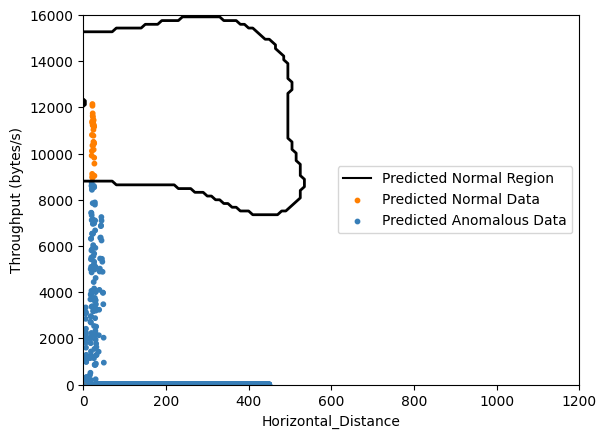

In [13]:
# test_data = pd.DataFrame([{"Horizontal_Distance": 500, "Height": 285, "UAV_Sending_Interval": 20, 
#                             "MCS_Index": 3, "UAV_Speed": 6, "Throughput": 10000}])
# # test_data[['Mean_SINR',"Std_Dev_SINR"]]= test_data.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
# test_data = normalize_data(test_data, columns=["Horizontal_Distance", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK) 

# Using horizontal distance and throughput only
# xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
# Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Using mean and std dev of SINR
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
max_h_dist = 1200
min_h_dist = 0
if LINK == "Downlink":
    max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
elif LINK == "Uplink":
    max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
elif LINK == "Video":
    max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
min_throughput = 0

xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = 2*yy/max_throughput - 1
mean_sinr = []
std_dev_sinr = []
height = throughput_test_df_norm["Height"].values[0]
usi = throughput_test_df_norm["UAV_Sending_Interval"].values[0]
mcs = throughput_test_df_norm["MCS_Index"].values[0]
speed = throughput_test_df_norm["UAV_Speed"].values[0]
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Get contour for model_1
# Z1 = model.predict(np.c_[mean_sinr, std_dev_sinr, np.ones(len(mean_sinr))*usi, np.ones(len(mean_sinr))*mcs, np.ones(len(mean_sinr))*speed, yy_norm.ravel()])
# Z1 = model.predict(np.c_[mean_sinr, std_dev_sinr, np.ones(len(mean_sinr))*speed, yy_norm.ravel()])
Z1 = model.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm.ravel()])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors="black")

y_pred_1 = model.predict(X_test)
colors = np.array(["#377eb8", "#ff7f00"])
plt.scatter(throughput_test_df["Horizontal_Distance"].values, throughput_test_df["Throughput"].values, s=10, color=colors[(y_pred_1 + 1) // 2], label="_nolegend_")
plt.plot([0], [0], color='k')
plt.scatter([0], [0], s=10, color='#ff7f00')
plt.scatter([0], [0], s=10, color='#377eb8')
plt.xlabel("Horizontal_Distance")
plt.ylabel("Throughput (bytes/s)")
plt.legend(["Predicted Normal Region", "Predicted Normal Data", "Predicted Anomalous Data"], loc='center right')

## Plot Local Outlier Detection Scores of Predictions

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# First, make sure to train the LOF using training data
lof_model = LocalOutlierFactor(n_neighbors=20, novelty=True, n_jobs=20)
lof_model.fit(X_train)

# Load testing data
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Test_Dataset_Anomaly_AllType_DJISpark_Throughput/data_processed/"
LINK = "Downlink"

throughput_test_df = get_measured_throughput(DATASET_PATH, LINK, single_path=False)
throughput_test_df["UAV_Speed"] = 12

# Find crit distance and filter DF
test_horizontal_dist = np.linspace(0, 1200, 121, endpoint=True)
test_height = throughput_test_df["Height"].values[0]
stop = 0
for h_dist in test_horizontal_dist:
    if stop == 0:
        m, s = sinr_lognormal_approx(h_dist, test_height)
        m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
        s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
        predicted_reliability = dl_model.predict([[m, s, uav_send_int_norm[uav_send_int], norm_MCS(mcs_index)]])[0][0]
        if predicted_reliability < reliability_th:
            stop = 1
            crit_dist = h_dist
throughput_test_df = throughput_test_df.loc[(throughput_test_df["Height"]==test_height) & (throughput_test_df["Horizontal_Distance"]<=crit_dist)]

throughput_test_df[['Mean_SINR',"Std_Dev_SINR"]]= throughput_test_df.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_test_df_norm = normalize_data(throughput_test_df, columns=["Horizontal_Distance", "Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK)              
# Get only inputs  for model
X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values

# Get the anomaly predictions and LOF scores
y_pred = model.predict(X_test)
lof_scores = lof_model.score_samples(X_test)
colors = np.array(["#377eb8", "#ff7f00"])
plt.scatter(throughput_test_df["Horizontal_Distance"].values, -lof_scores, s=10, color=colors[(y_pred + 1) // 2], label="_nolegend_")
plt.xlabel("Horizontal_Distance")
plt.ylabel("Local Outlier Factor")


# Waypoint Control Mode

## Load Training Data

In [133]:
pandarallel.initialize(progress_bar=False)
# FOR SINGLE SCENARIO
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/temp_plot/UAVSpeed-6_BitRate-6.5_Height-270_Distance-1200_Modulation-BPSK_UAVSendingInterval-1000/" 
LINK = "Uplink"
throughput_df = get_measured_throughput(DATASET_PATH, LINK, single_path=True)

"""Filter scenario"""
reliability_threshold = 0.99
throughput_df = throughput_df.loc[(throughput_df["Measured_Reliability"]>=reliability_threshold)]

# Get SNR and normalize data
throughput_df[['Mean_SINR',"Std_Dev_SINR"]] = throughput_df.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_df = normalize_data(throughput_df, columns=["Mean_SINR", "Std_Dev_SINR"], link=LINK)              
throughput_scaler = RobustScaler().fit(throughput_df["Throughput"].to_numpy().reshape(-1, 1))
throughput_df["Throughput_Norm"] = throughput_scaler.transform(throughput_df["Throughput"].to_numpy().reshape(-1, 1))

# Get only inputs  for model
X_train = throughput_df[["Mean_SINR", "Std_Dev_SINR", "Throughput_Norm"]].values


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|██████████| 1/1 [00:00<00:00, 40.83it/s]


## Train One Class SVM

In [121]:
from sklearn.svm import OneClassSVM

model = OneClassSVM(kernel='rbf', nu=1e-3, gamma=5)

model.fit(X_train)

OneClassSVM(gamma=5, nu=0.001)

## Plot learnt boundary

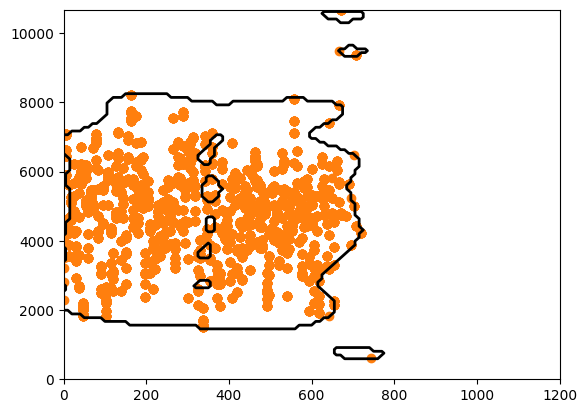

In [122]:
'''Plotting contour of model'''
# Using mean and std dev of SINR
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
max_h_dist = 1200
min_h_dist = 0
max_throughput = throughput_df["Throughput"].max()
min_throughput = 0

# yy_notnorm = np.linspace(min_throughput, max_throughput, 100)
# yy_norm = throughput_scaler.transform(yy_notnorm.reshape(-1,1))
xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = throughput_scaler.transform(yy.reshape(-1,1))
mean_sinr = []
std_dev_sinr = []
height = throughput_df["Height"].values[0]
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Get contour for model
Z1 = model.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors="black")

plt.scatter(throughput_df["Horizontal_Distance"], throughput_df["Throughput"], color="tab:orange")

# For Miscellaneous Plotting Purposes - 05/01/2024

In [135]:
pandarallel.initialize(progress_bar=False)
# FOR SINGLE SCENARIO
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/temp_plot_2/UAVSpeed-6_BitRate-13_Height-270_Distance-1200_Modulation-QPSK_UAVSendingInterval-100/" 
LINK = "Uplink"
throughput_df_2 = get_measured_throughput(DATASET_PATH, LINK, single_path=True)

"""Filter scenario"""
reliability_threshold = 0.99
throughput_df_2 = throughput_df_2.loc[(throughput_df_2["Measured_Reliability"]>=reliability_threshold)]

# Get SNR and normalize data
throughput_df_2[['Mean_SINR',"Std_Dev_SINR"]] = throughput_df_2.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_df_2 = normalize_data(throughput_df_2, columns=["Mean_SINR", "Std_Dev_SINR"], link=LINK)              
throughput_scaler_2 = RobustScaler().fit(throughput_df_2["Throughput"].to_numpy().reshape(-1, 1))
throughput_df_2["Throughput_Norm"] = throughput_scaler_2.transform(throughput_df_2["Throughput"].to_numpy().reshape(-1, 1))

# Get only inputs  for model
X_train_2 = throughput_df_2[["Mean_SINR", "Std_Dev_SINR", "Throughput_Norm"]].values

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|██████████| 1/1 [00:00<00:00, 80.68it/s]


In [114]:
model_2 = OneClassSVM(kernel='rbf', nu=1e-3, gamma=3)

model_2.fit(X_train_2)

OneClassSVM(gamma=3, nu=0.001)

Text(0, 0.5, 'Throughput (bytes/sec)')

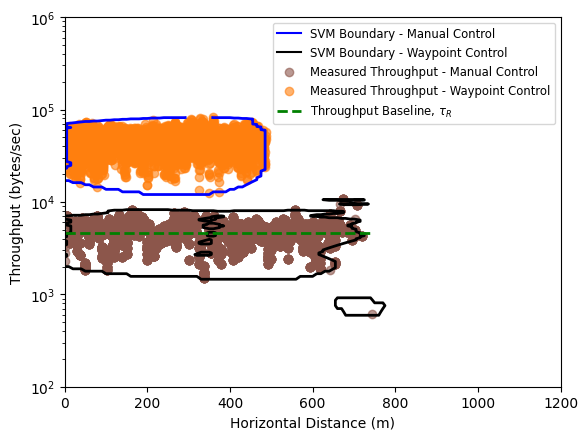

In [145]:
'''Plotting contour of model'''
# Using mean and std dev of SINR
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
max_h_dist = 1200
min_h_dist = 0
max_throughput = throughput_df["Throughput"].max()
min_throughput = 0

# yy_notnorm = np.linspace(min_throughput, max_throughput, 100)
# yy_norm = throughput_scaler.transform(yy_notnorm.reshape(-1,1))
xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = throughput_scaler.transform(yy.reshape(-1,1))
mean_sinr = []
std_dev_sinr = []
height = throughput_df["Height"].values[0]
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Get contour for model
Z1 = model.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors="black")

max_throughput = throughput_df_2["Throughput"].max()
xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = throughput_scaler_2.transform(yy.reshape(-1,1))
mean_sinr = []
std_dev_sinr = []
height = throughput_df_2["Height"].values[0]
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Get contour for model
Z2 = model_2.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm])
Z2 = Z2.reshape(xx.shape)
plt.contour(xx, yy, Z2, levels=[0], linewidths=2, colors="blue")

# DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/temp_plot/UAVSpeed-6_BitRate-6.5_Height-270_Distance-1200_Modulation-BPSK_UAVSendingInterval-1000/" 
# throughput_df = get_measured_throughput(DATASET_PATH, LINK, single_path=True)
# DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/temp_plot_2/UAVSpeed-6_BitRate-13_Height-270_Distance-1200_Modulation-QPSK_UAVSendingInterval-100/" 
# throughput_df_2 = get_measured_throughput(DATASET_PATH, LINK, single_path=True)
# temp_df = throughput_df[(throughput_df["Horizontal_Distance"]>=450) & (throughput_df["Measured_Reliability"]>=reliability_threshold)]
# temp_df_2 = throughput_df_2[throughput_df_2["Horizontal_Distance"]<=550]

movingAvgThroughput = 4593.15 # In bytes/sec
plt.plot([0], [1], color='blue')
plt.plot([0], [1], color='black')
plt.scatter(throughput_df["Horizontal_Distance"], throughput_df["Throughput"], color="tab:brown", alpha=0.6)
plt.scatter(throughput_df_2["Horizontal_Distance"], throughput_df_2["Throughput"], color="tab:orange", alpha=0.6)
plt.plot([0, throughput_df["Horizontal_Distance"].max()], [movingAvgThroughput, movingAvgThroughput], '--g', linewidth=2)
plt.ylim(100, 1000000)
plt.yscale('log')
plt.legend(["SVM Boundary - Manual Control", "SVM Boundary - Waypoint Control", "Measured Throughput - Manual Control", 
            "Measured Throughput - Waypoint Control", "Throughput Baseline, $τ_{R}$"], loc='upper right', fontsize='small')
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Throughput (bytes/sec)")

100%|██████████| 1/1 [00:00<00:00, 39.75it/s]


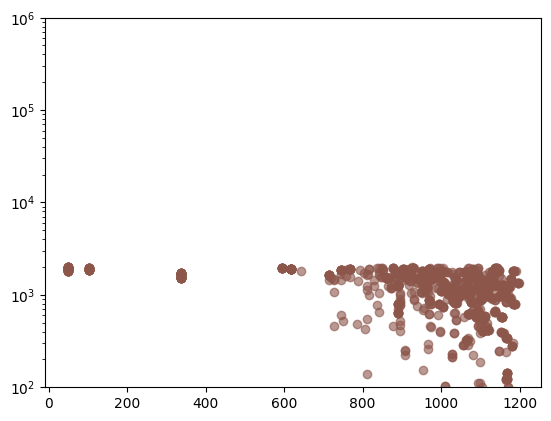

In [150]:
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/temp_plot/UAVSpeed-6_BitRate-6.5_Height-270_Distance-1200_Modulation-BPSK_UAVSendingInterval-1000/" 
throughput_df = get_measured_throughput(DATASET_PATH, LINK, single_path=True)
throughput_df = throughput_df.loc[throughput_df["Throughput"] < 2000]
plt.scatter(throughput_df["Horizontal_Distance"], throughput_df["Throughput"], color="tab:brown", alpha=0.6)
plt.ylim(100, 1000000)
plt.yscale('log')